# Daily Candlestick Color - Detection(Predict, Classification, Clustering)

### Import Library

In [166]:
import numpy as np
import pandas as pd
import numpy as np
import pandas_ta as ta
import seaborn as sns

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['figure.dpi'] = 120
import warnings
warnings.filterwarnings('ignore')

### Load Price Data

In [167]:
import os
from pathlib import Path
notebook_path = os.getcwd()
current_dir = Path(notebook_path)
csv_file = str(current_dir) + '/VN30F1M_5minutes.csv'
is_file = os.path.isfile(csv_file)
if is_file:
    dataset = pd.read_csv(csv_file, index_col='Date', parse_dates=True)
else:
    print('remote')
    dataset = pd.read_csv("https://raw.githubusercontent.com/zuongthaotn/vn-stock-data/main/VN30ps/VN30F1M_5minutes.csv", index_col='Date', parse_dates=True)

In [168]:
data = dataset.copy()

In [169]:
data

,Open,High,Low,Close,Volume
Date,,,,,
2018-08-13 09:00:00,943.5,943.6,942.9,943.1,1812
2018-08-13 09:05:00,943.1,943.5,942.9,943.3,1323
2018-08-13 09:10:00,943.2,943.3,942.6,943.1,1207
2018-08-13 09:15:00,943.1,943.1,942.3,942.6,1196
2018-08-13 09:20:00,942.6,943.7,942.4,943.7,1765
...,...,...,...,...,...
2025-02-14 14:15:00,1343.0,1343.0,1340.3,1341.3,7141
2025-02-14 14:20:00,1340.9,1341.9,1340.5,1341.4,4593
2025-02-14 14:25:00,1341.1,1342.5,1340.7,1342.5,4207


## Prepare labels

In [170]:
daily_data = data.resample('D').agg({
        'Volume': 'sum',
        'Open': 'first',
        'Close': 'last',
        'High': 'max',
        'Low': 'min'
    })
daily_data.dropna(subset=['Close'], inplace=True)
daily_data["color"] = daily_data.apply(lambda r: "Doji" if r["Close"] == r["Open"] else ("Green" if r["Close"] > r["Open"] else "Red") , axis=1)
daily_data["color_int"] = daily_data.apply(lambda r: 0 if r["color"] == "Doji" else (1 if r["color"] == "Green" else 2), axis=1)

In [171]:
daily_data

,Volume,Open,Close,High,Low,color,color_int
Date,,,,,,,
2018-08-13,79327,943.5,954.2,954.6,942.3,Green,1
2018-08-14,79266,955.5,959.3,961.8,952.1,Green,1
2018-08-15,89449,958.0,946.6,962.3,946.6,Red,2
2018-08-16,71410,942.4,947.0,947.3,935.5,Green,1
2018-08-17,98531,952.2,947.0,954.6,945.0,Red,2
...,...,...,...,...,...,...,...
2025-02-10,185266,1333.4,1330.5,1337.6,1325.2,Red,2
2025-02-11,143632,1332.5,1334.1,1334.1,1327.6,Green,1
2025-02-12,139180,1337.4,1329.5,1342.0,1329.5,Red,2


## Feature Engineering

In [172]:
daily_data['RSI_5'] = ta.rsi(daily_data["Close"], length=5)
daily_data['RSI_10'] = ta.rsi(daily_data["Close"], length=10)
daily_data['RSI_22'] = ta.rsi(daily_data["Close"], length=22)
daily_data['ibs'] = daily_data.apply(lambda r: (r["Close"] - r["Low"]) / (r["High"] - r["Low"]), axis=1)
daily_data["ibs_hqua"] = daily_data["ibs"].shift(-1)
daily_data["ibs_hkia"] = daily_data["ibs"].shift(-2)
daily_data["ibs_3htruoc"] = daily_data["ibs"].shift(-3)
daily_data["next_Open"] = daily_data["Open"].shift(-1)
daily_data["NODC"] = daily_data["next_Open"] - daily_data["Close"]
daily_data["NODH"] = daily_data["next_Open"] - daily_data["High"]
daily_data["NODL"] = daily_data["next_Open"] - daily_data["Low"]
daily_data['Close_pct'] = daily_data['Close'].pct_change() * 100
daily_data['Volume_pct'] = daily_data['Volume'].pct_change() * 100
daily_data["next_color"] = daily_data["color_int"].shift(-1)
daily_data.dropna(inplace=True)

## AI prediction

In [173]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from sklearn import metrics
from xgboost import plot_importance
from sklearn.cluster import KMeans

## Kmeans

In [174]:
cluster1 = KMeans(n_clusters=15, n_init=2).fit(daily_data[["RSI_5", "RSI_10", "RSI_22"]])
daily_data = daily_data.assign(cluster1=cluster1.labels_)

In [175]:
cluster2 = KMeans(n_clusters=20, n_init=2).fit(daily_data[["ibs", "ibs_hqua", "ibs_hkia", "ibs_3htruoc"]])
daily_data = daily_data.assign(cluster2=cluster2.labels_)

In [176]:
cluster3 = KMeans(n_clusters=30, n_init=2).fit(daily_data[["NODC", "NODH", "NODL"]])
daily_data = daily_data.assign(cluster3=cluster3.labels_)

In [177]:
cluster4 = KMeans(n_clusters=50, n_init=2).fit(daily_data[["Close_pct", "Volume_pct"]])
daily_data = daily_data.assign(cluster4=cluster4.labels_)

In [178]:
daily_data

,Volume,Open,Close,High,Low,color,color_int,RSI_5,RSI_10,RSI_22,...,NODC,NODH,NODL,Close_pct,Volume_pct,next_color,cluster1,cluster2,cluster3,cluster4
Date,,,,,,,,,,,,,,,,,,,,,
2018-08-14,79266,955.5,959.3,961.8,952.1,Green,1,100.000000,100.000000,100.000000,...,-1.3,-3.8,5.9,0.534479,-0.076897,2.0,5,18,22,13
2018-08-15,89449,958.0,946.6,962.3,946.6,Red,2,61.631420,78.327645,89.398998,...,-4.2,-19.9,-4.2,-1.323882,12.846618,1.0,6,6,2,4
2018-08-16,71410,942.4,947.0,947.3,935.5,Green,1,62.202381,78.490779,89.435950,...,5.2,4.9,16.7,0.042256,-20.166799,2.0,6,14,10,42
2018-08-17,98531,952.2,947.0,954.6,945.0,Red,2,62.202381,78.490779,89.435950,...,-0.9,-8.5,1.1,0.000000,37.979275,2.0,6,8,8,30
2018-08-20,88210,946.1,945.0,951.5,942.6,Red,2,55.724046,75.005661,87.757338,...,-0.3,-6.8,2.1,-0.211193,-10.474876,1.0,6,2,18,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-02-05,160904,1331.6,1333.5,1337.8,1329.6,Green,1,58.948134,56.054240,53.005123,...,2.1,-2.2,6.0,0.376364,-6.459864,1.0,11,2,4,45
2025-02-06,158566,1335.6,1339.9,1344.9,1335.6,Green,1,64.564670,59.225510,54.687809,...,-1.4,-6.4,2.9,0.479940,-1.453040,1.0,12,13,18,40
2025-02-07,170155,1338.5,1343.3,1347.4,1335.0,Green,1,67.515978,60.891396,55.573130,...,-9.9,-14.0,-1.6,0.253750,7.308629,2.0,4,18,12,24


### Xgboost

In [179]:
# Define Features and Target Variable
features = ["cluster1", "cluster2", "cluster3", "cluster4"]
X = daily_data
y = daily_data["next_color"]

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train = X_train[features]
X_test2 = X_test[features]
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test2_scaled = scaler.fit_transform(X_test2)

In [180]:
# Create XGBClassifier model
model_xgb = xgb.XGBClassifier(n_estimators=50, random_state=42)

# Train XGBClassifier
model_xgb = model_xgb.fit(X_train_scaled, y_train)

# Predict the response for test dataset
y2_pred = model_xgb.predict(X_test2)
# Model Accuracy, how often is the classifier correct?
print("Accuracy:", metrics.accuracy_score(y_test, y2_pred))

Accuracy: 0.49382716049382713


<Axes: title={'center': 'Feature importance'}, xlabel='Importance score', ylabel='Features'>

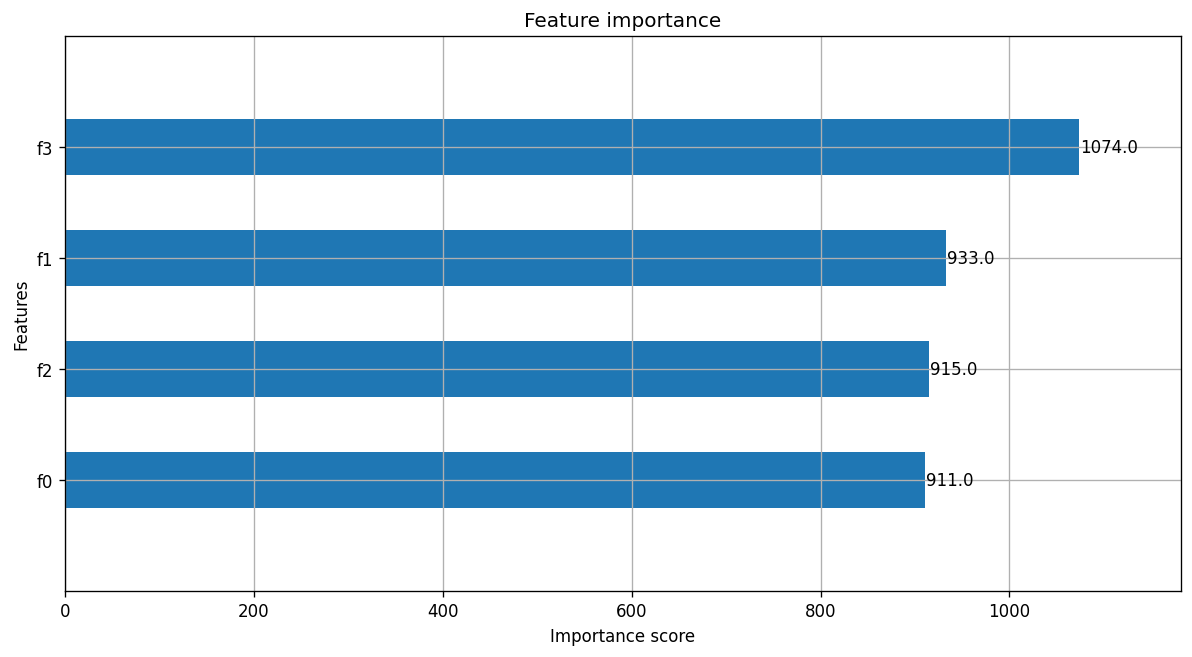

In [181]:
plot_importance(model_xgb, max_num_features=20, height=0.5)